In [19]:
# Step 0: Install missing packages
!pip install shap xgboost fastdtw scipy


In [20]:
!pip install patool

# Step 1: Mount Google Drive

In [21]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 2: Extract UCI & PHYTMO

In [22]:
import os, zipfile, patoolib

uci_zip_path = "/content/drive/MyDrive/physio/physical+therapy+exercises+dataset.zip"
uci_extract_path = "/content/uci_dataset"

if not os.path.exists(uci_extract_path):
    print("Extracting UCI dataset...")
    with zipfile.ZipFile(uci_zip_path, 'r') as z:
        z.extractall(uci_extract_path)
    print("UCI extracted at", uci_extract_path)
else:
    print("UCI already extracted at", uci_extract_path)

phytmo_zip_path = "/content/drive/MyDrive/physio/PHYTMO.zip"
phytmo_extract_path = "/content/phytmo_dataset"

if not os.path.exists(phytmo_extract_path):
    print("Extracting PHYTMO dataset...")
    patoolib.extract_archive(phytmo_zip_path, outdir=phytmo_extract_path)
    print("PHYTMO extracted at", phytmo_extract_path)
else:
    print("PHYTMO already extracted at", phytmo_extract_path)

UCI already extracted at /content/uci_dataset
PHYTMO already extracted at /content/phytmo_dataset


#Step 3: Imports

In [23]:
import numpy as np
import pandas as pd
import glob, re
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import joblib, gc

# Step 4: Helper functions

In [24]:
def read_numeric_txt(path, delimiter=';'):
    try:
        df = pd.read_csv(path, sep=delimiter, header=None, engine='python')
    except Exception:
        with open(path, 'r') as f:
            lines = [ln.strip() for ln in f.readlines() if ln.strip()]
        if any(c.isalpha() for c in lines[0]):
            lines = lines[1:]
        rows = [re.split(r'\s*;\s*', ln) for ln in lines]
        df = pd.DataFrame(rows)
    df = df.apply(lambda col: pd.to_numeric(col.astype(str).str.replace(',', '.'), errors='coerce'))
    df = df.dropna(axis=1, how='all').dropna(axis=0, how='all')
    return df.values

def pad_or_truncate(seg, window=200):
    T, C = seg.shape
    if T == window:
        return seg
    if T < window:
        pad = np.zeros((window - T, C))
        return np.vstack([seg, pad])
    start = max(0, (T - window)//2)
    return seg[start:start+window, :]

def segment_signal(data, window_size=200, step_size=200):
    segments = []
    for start in range(0, len(data) - window_size + 1, step_size):
        segments.append(data[start:start+window_size])
    return segments



#Step 5: Load UCI dataset

In [25]:
label_names = ['correct', 'fast', 'low_amplitude']
uci_X_segments, uci_y_segments, uci_meta = [], [], []

subjects = ['s1', 's2']  # Expand if more subjects available
for subj in subjects:
    subj_dir = os.path.join(uci_extract_path, subj)
    if not os.path.isdir(subj_dir):
        print(f"Skipping {subj}: Directory not found")
        continue
    exercises = sorted([d for d in os.listdir(subj_dir) if re.match(r'e\d+', d)])
    for ex in exercises:
        ex_dir = os.path.join(subj_dir, ex)
        unit_dirs = sorted([d for d in os.listdir(ex_dir) if re.match(r'u\d+', d)])
        for u in unit_dirs:
            unit_dir = os.path.join(ex_dir, u)
            template_file = os.path.join(unit_dir, "template_session.txt")
            if not os.path.exists(template_file):
                continue
            arr = read_numeric_txt(template_file)
            if arr.size == 0:
                continue
            N = arr.shape[0]
            thirds = N // 3
            for idx in range(3):
                s = idx * thirds
                e = (idx+1)*thirds if idx<2 else N
                seg = arr[s:e, :]
                uci_X_segments.append(seg)
                uci_y_segments.append(label_names[idx])
                uci_meta.append((subj, ex, u, template_file, s, e))

uci_X_fixed = np.stack([pad_or_truncate(x, 200) for x in uci_X_segments], axis=0)
uci_y_array = np.array(uci_y_segments)
print("UCI final shape:", uci_X_fixed.shape, "Labels:", pd.Series(uci_y_array).value_counts())

UCI final shape: (240, 200, 10) Labels: correct          80
fast             80
low_amplitude    80
Name: count, dtype: int64


# Step 6: Load PHYTMO dataset

In [26]:
phytmo_path = os.path.join(phytmo_extract_path, "inertial")
phytmo_csvs = glob.glob(os.path.join(phytmo_path, "**/*.csv"), recursive=True)
print("PHYTMO CSVs found:", len(phytmo_csvs))

def load_phytmo_csv(file):
    try:
        df = pd.read_csv(file)
        if "time" in df.columns:
            df = df.drop(columns=["time"])
        if df.shape[1] < 9:
            pad_cols = np.zeros((df.shape[0], 9 - df.shape[1]))
            df = pd.concat([df, pd.DataFrame(pad_cols)], axis=1)
        elif df.shape[1] > 9:
            df = df.iloc[:, :9]
        return df.values
    except Exception as e:
        print(f"Error loading {file}: {e}")
        return None

phytmo_segments, phytmo_labels = [], []

for file in tqdm(phytmo_csvs):  # Process all files, not just 500
    arr = load_phytmo_csv(file)
    if arr is None or arr.shape[1] != 9:
        continue
    parts = file.split(os.sep)
    label_folder = parts[-3]  # A, B, C, D, or E
    body_part = parts[-2]     # lower or upper
    label = f"PHYTMO_{body_part}_{label_folder}"
    segs = segment_signal(arr)
    for seg in segs:
        phytmo_segments.append(seg)
        phytmo_labels.append(label)

phytmo_X = np.array(phytmo_segments)
phytmo_y = np.array(phytmo_labels)
print("PHYTMO final shape:", phytmo_X.shape, "Labels:", set(phytmo_y))



PHYTMO CSVs found: 4868


100%|██████████| 4868/4868 [01:15<00:00, 64.41it/s]


PHYTMO final shape: (90593, 200, 9) Labels: {np.str_('PHYTMO_Lforearm_E'), np.str_('PHYTMO_Rthigh_D'), np.str_('PHYTMO_Lshin_E'), np.str_('PHYTMO_Lforearm_D'), np.str_('PHYTMO_Rthigh_E'), np.str_('PHYTMO_Larm_E'), np.str_('PHYTMO_Rthigh_C'), np.str_('PHYTMO_Larm_C'), np.str_('PHYTMO_Rarm_E'), np.str_('PHYTMO_Rshin_D'), np.str_('PHYTMO_Larm_A'), np.str_('PHYTMO_Rarm_B'), np.str_('PHYTMO_Rarm_C'), np.str_('PHYTMO_Rforearm_D'), np.str_('PHYTMO_Rforearm_C'), np.str_('PHYTMO_Rforearm_A'), np.str_('PHYTMO_Lthigh_E'), np.str_('PHYTMO_Lthigh_A'), np.str_('PHYTMO_Rshin_E'), np.str_('PHYTMO_Rarm_A'), np.str_('PHYTMO_Rthigh_A'), np.str_('PHYTMO_Lshin_C'), np.str_('PHYTMO_Lforearm_A'), np.str_('PHYTMO_Rshin_A'), np.str_('PHYTMO_Larm_D'), np.str_('PHYTMO_Lthigh_B'), np.str_('PHYTMO_Rshin_C'), np.str_('PHYTMO_Lthigh_D'), np.str_('PHYTMO_Larm_B'), np.str_('PHYTMO_Lforearm_B'), np.str_('PHYTMO_Lshin_D'), np.str_('PHYTMO_Lshin_A'), np.str_('PHYTMO_Rarm_D'), np.str_('PHYTMO_Lforearm_C'), np.str_('PHYTMO

# Step 7: Combine UCI + PHYTMO

In [27]:
uci_X_resized = uci_X_fixed[:, :, :9]
uci_y_prefixed = np.array(["UCI_" + y for y in uci_y_array])

X_combined = np.concatenate([uci_X_resized, phytmo_X], axis=0)
y_combined = np.concatenate([uci_y_prefixed, phytmo_y], axis=0)
print("Combined shape:", X_combined.shape, "Labels:", set(y_combined))

Combined shape: (90833, 200, 9) Labels: {np.str_('UCI_low_amplitude'), np.str_('PHYTMO_Lforearm_E'), np.str_('PHYTMO_Rthigh_D'), np.str_('PHYTMO_Lshin_E'), np.str_('PHYTMO_Lforearm_D'), np.str_('PHYTMO_Rthigh_E'), np.str_('UCI_correct'), np.str_('PHYTMO_Larm_E'), np.str_('PHYTMO_Rthigh_C'), np.str_('PHYTMO_Larm_C'), np.str_('PHYTMO_Rarm_E'), np.str_('PHYTMO_Rshin_D'), np.str_('PHYTMO_Larm_A'), np.str_('PHYTMO_Rarm_B'), np.str_('PHYTMO_Rarm_C'), np.str_('PHYTMO_Rforearm_D'), np.str_('PHYTMO_Rforearm_C'), np.str_('PHYTMO_Rforearm_A'), np.str_('PHYTMO_Lthigh_E'), np.str_('PHYTMO_Lthigh_A'), np.str_('UCI_fast'), np.str_('PHYTMO_Rshin_E'), np.str_('PHYTMO_Rarm_A'), np.str_('PHYTMO_Rthigh_A'), np.str_('PHYTMO_Lshin_C'), np.str_('PHYTMO_Lforearm_A'), np.str_('PHYTMO_Rshin_A'), np.str_('PHYTMO_Larm_D'), np.str_('PHYTMO_Lthigh_B'), np.str_('PHYTMO_Rshin_C'), np.str_('PHYTMO_Lthigh_D'), np.str_('PHYTMO_Larm_B'), np.str_('PHYTMO_Lforearm_B'), np.str_('PHYTMO_Lshin_D'), np.str_('PHYTMO_Lshin_A'), 

# Step 8: Feature extraction

In [28]:
def extract_features(segments):
    features = []
    for seg in segments:
        mean = np.mean(seg, axis=0)
        std = np.std(seg, axis=0)
        max_val = np.max(seg, axis=0)
        min_val = np.min(seg, axis=0)
        range_val = max_val - min_val
        fft = np.abs(np.fft.fft(seg, axis=0))[:10].flatten()
        feat = np.concatenate([mean, std, max_val, min_val, range_val, fft])
        features.append(feat)
    return np.array(features)

X_features = extract_features(X_combined)
le = LabelEncoder()
y_enc = le.fit_transform(y_combined)
print("Classes:", list(le.classes_))



Classes: [np.str_('PHYTMO_Larm_A'), np.str_('PHYTMO_Larm_B'), np.str_('PHYTMO_Larm_C'), np.str_('PHYTMO_Larm_D'), np.str_('PHYTMO_Larm_E'), np.str_('PHYTMO_Lforearm_A'), np.str_('PHYTMO_Lforearm_B'), np.str_('PHYTMO_Lforearm_C'), np.str_('PHYTMO_Lforearm_D'), np.str_('PHYTMO_Lforearm_E'), np.str_('PHYTMO_Lshin_A'), np.str_('PHYTMO_Lshin_B'), np.str_('PHYTMO_Lshin_C'), np.str_('PHYTMO_Lshin_D'), np.str_('PHYTMO_Lshin_E'), np.str_('PHYTMO_Lthigh_A'), np.str_('PHYTMO_Lthigh_B'), np.str_('PHYTMO_Lthigh_C'), np.str_('PHYTMO_Lthigh_D'), np.str_('PHYTMO_Lthigh_E'), np.str_('PHYTMO_Rarm_A'), np.str_('PHYTMO_Rarm_B'), np.str_('PHYTMO_Rarm_C'), np.str_('PHYTMO_Rarm_D'), np.str_('PHYTMO_Rarm_E'), np.str_('PHYTMO_Rforearm_A'), np.str_('PHYTMO_Rforearm_B'), np.str_('PHYTMO_Rforearm_C'), np.str_('PHYTMO_Rforearm_D'), np.str_('PHYTMO_Rforearm_E'), np.str_('PHYTMO_Rshin_A'), np.str_('PHYTMO_Rshin_B'), np.str_('PHYTMO_Rshin_C'), np.str_('PHYTMO_Rshin_D'), np.str_('PHYTMO_Rshin_E'), np.str_('PHYTMO_Rthi

In [29]:
import joblib

joblib.dump(le, "label_encoder.pkl")
print("Saved the Label Encoder (le) to label_encoder.pkl")

Saved the Label Encoder (le) to label_encoder.pkl


# Step 9: Train/Validation/Test Split

In [30]:
# First split: 85% train+val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X_features, y_enc, test_size=0.15, random_state=42, stratify=y_enc)

# Second split: 70% train, 15% val from remaining
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)  # 0.1765 ≈ 15/85

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

gc.collect()

print("Train shape:", X_train.shape, "Val shape:", X_val.shape, "Test shape:", X_test.shape)
print("Train labels:", pd.Series(y_train).value_counts())
print("Val labels:", pd.Series(y_val).value_counts())
print("Test labels:", pd.Series(y_test).value_counts())

Train shape: (63580, 135) Val shape: (13628, 135) Test shape: (13625, 135)
Train labels: 30    4455
15    4449
35    4448
10    4442
0     1976
20    1972
5     1970
25    1967
11    1774
31    1773
36    1771
16    1771
33    1718
13    1714
38    1710
18    1710
12    1524
37    1512
32    1509
17    1507
34    1384
14    1377
19    1375
39    1374
6      952
26     950
21     945
1      926
8      752
3      751
23     741
28     739
22     697
2      693
27     693
7      693
24     678
9      675
29     675
4      670
42      56
41      56
40      56
Name: count, dtype: int64
Val labels: 30    955
15    953
35    953
10    952
0     424
25    422
5     422
20    422
11    380
16    380
31    380
36    380
33    368
18    367
38    367
13    367
12    326
37    324
17    323
32    323
34    297
14    295
19    295
39    295
26    204
6     204
21    203
1     199
3     161
8     161
23    159
28    158
7     149
22    149
27    149
2     149
24    145
4     144
9     144
29    144


# Step 10: Train Random Forest with validation

In [31]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight=class_weight_dict)
rf.fit(X_train_scaled, y_train)

# Evaluate on validation set
yp_val_rf = rf.predict(X_val_scaled)
acc_val_rf = accuracy_score(y_val, yp_val_rf) # Get accuracy score

# Evaluate on test set
yp_test_rf = rf.predict(X_test_scaled)
acc_test_rf = accuracy_score(y_test, yp_test_rf) # Get accuracy score

# --- New lines to store accuracies ---
model_accuracies = {} # Initialize the dictionary
model_accuracies['RF_Validation'] = acc_val_rf
model_accuracies['RF_Test'] = acc_test_rf
# --- End of new lines ---

print("RF Validation Accuracy:", acc_val_rf)
print(classification_report(y_val, yp_val_rf, target_names=le.classes_))

print("RF Test Accuracy:", acc_test_rf)
print(classification_report(y_test, yp_test_rf, target_names=le.classes_))

RF Validation Accuracy: 0.7790578221309069
                   precision    recall  f1-score   support

    PHYTMO_Larm_A       0.75      0.90      0.82       424
    PHYTMO_Larm_B       0.91      0.80      0.86       199
    PHYTMO_Larm_C       0.88      0.71      0.79       149
    PHYTMO_Larm_D       0.92      0.55      0.69       161
    PHYTMO_Larm_E       0.85      0.94      0.89       144
PHYTMO_Lforearm_A       0.72      0.92      0.81       422
PHYTMO_Lforearm_B       0.84      0.75      0.79       204
PHYTMO_Lforearm_C       0.92      0.64      0.76       149
PHYTMO_Lforearm_D       0.96      0.57      0.72       161
PHYTMO_Lforearm_E       0.83      0.72      0.77       144
   PHYTMO_Lshin_A       0.69      0.94      0.80       952
   PHYTMO_Lshin_B       0.86      0.64      0.74       380
   PHYTMO_Lshin_C       0.81      0.65      0.72       326
   PHYTMO_Lshin_D       0.86      0.56      0.68       367
   PHYTMO_Lshin_E       0.79      0.79      0.79       295
  PHYTMO_Lth

# Step 11: Train XGBoost with validation

In [32]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dval = xgb.DMatrix(X_val_scaled, label=y_val)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

params = {
    'objective': 'multi:softprob',
    'num_class': len(le.classes_),
    'eval_metric': 'mlogloss',
    'random_state': 42
}
evals = [(dtrain, 'train'), (dval, 'val')]
xgb_model = xgb.train(params, dtrain, num_boost_round=200, evals=evals, early_stopping_rounds=10, verbose_eval=False)

# Evaluate on validation set
yp_val_xgb = xgb_model.predict(dval).argmax(axis=1)
acc_val_xgb = accuracy_score(y_val, yp_val_xgb) # Get accuracy score

# Evaluate on test set
yp_test_xgb = xgb_model.predict(dtest).argmax(axis=1)
acc_test_xgb = accuracy_score(y_test, yp_test_xgb) # Get accuracy score

# --- New lines to store accuracies ---
model_accuracies['XGB_Validation'] = acc_val_xgb
model_accuracies['XGB_Test'] = acc_test_xgb
# --- End of new lines ---

print("XGBoost Validation Accuracy:", acc_val_xgb)
print(classification_report(y_val, yp_val_xgb, target_names=le.classes_))

print("XGBoost Test Accuracy:", acc_test_xgb)
print(classification_report(y_test, yp_test_xgb, target_names=le.classes_))

XGBoost Validation Accuracy: 0.8237452304079835
                   precision    recall  f1-score   support

    PHYTMO_Larm_A       0.84      0.90      0.87       424
    PHYTMO_Larm_B       0.89      0.86      0.88       199
    PHYTMO_Larm_C       0.83      0.77      0.80       149
    PHYTMO_Larm_D       0.90      0.75      0.81       161
    PHYTMO_Larm_E       0.85      0.84      0.85       144
PHYTMO_Lforearm_A       0.80      0.90      0.84       422
PHYTMO_Lforearm_B       0.87      0.81      0.84       204
PHYTMO_Lforearm_C       0.88      0.71      0.79       149
PHYTMO_Lforearm_D       0.87      0.77      0.82       161
PHYTMO_Lforearm_E       0.85      0.80      0.82       144
   PHYTMO_Lshin_A       0.80      0.90      0.85       952
   PHYTMO_Lshin_B       0.82      0.76      0.79       380
   PHYTMO_Lshin_C       0.81      0.74      0.78       326
   PHYTMO_Lshin_D       0.82      0.77      0.80       367
   PHYTMO_Lshin_E       0.80      0.80      0.80       295
  PHYTM

# Step 12: Visualize Model Accuracy Comparison

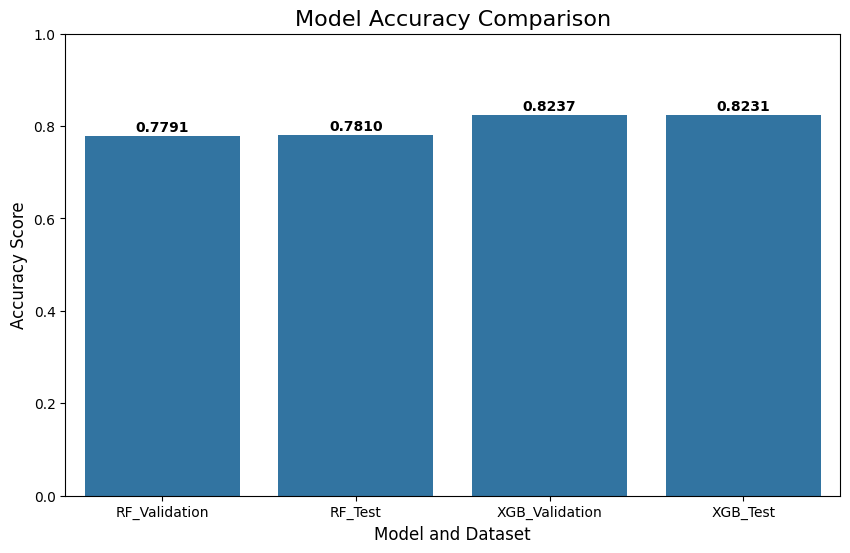

In [33]:
acc_names = list(model_accuracies.keys())
acc_values = list(model_accuracies.values())

plt.figure(figsize=(10, 6))
s = sns.barplot(x=acc_names, y=acc_values)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('Model and Dataset', fontsize=12)

# Add text labels to the bars
for i, v in enumerate(acc_values):
    s.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')

plt.ylim(0, 1.0) # Set Y-axis from 0 to 1
plt.show()

# Step 13: Confusion Matrix (for best model: XGBoost Test)

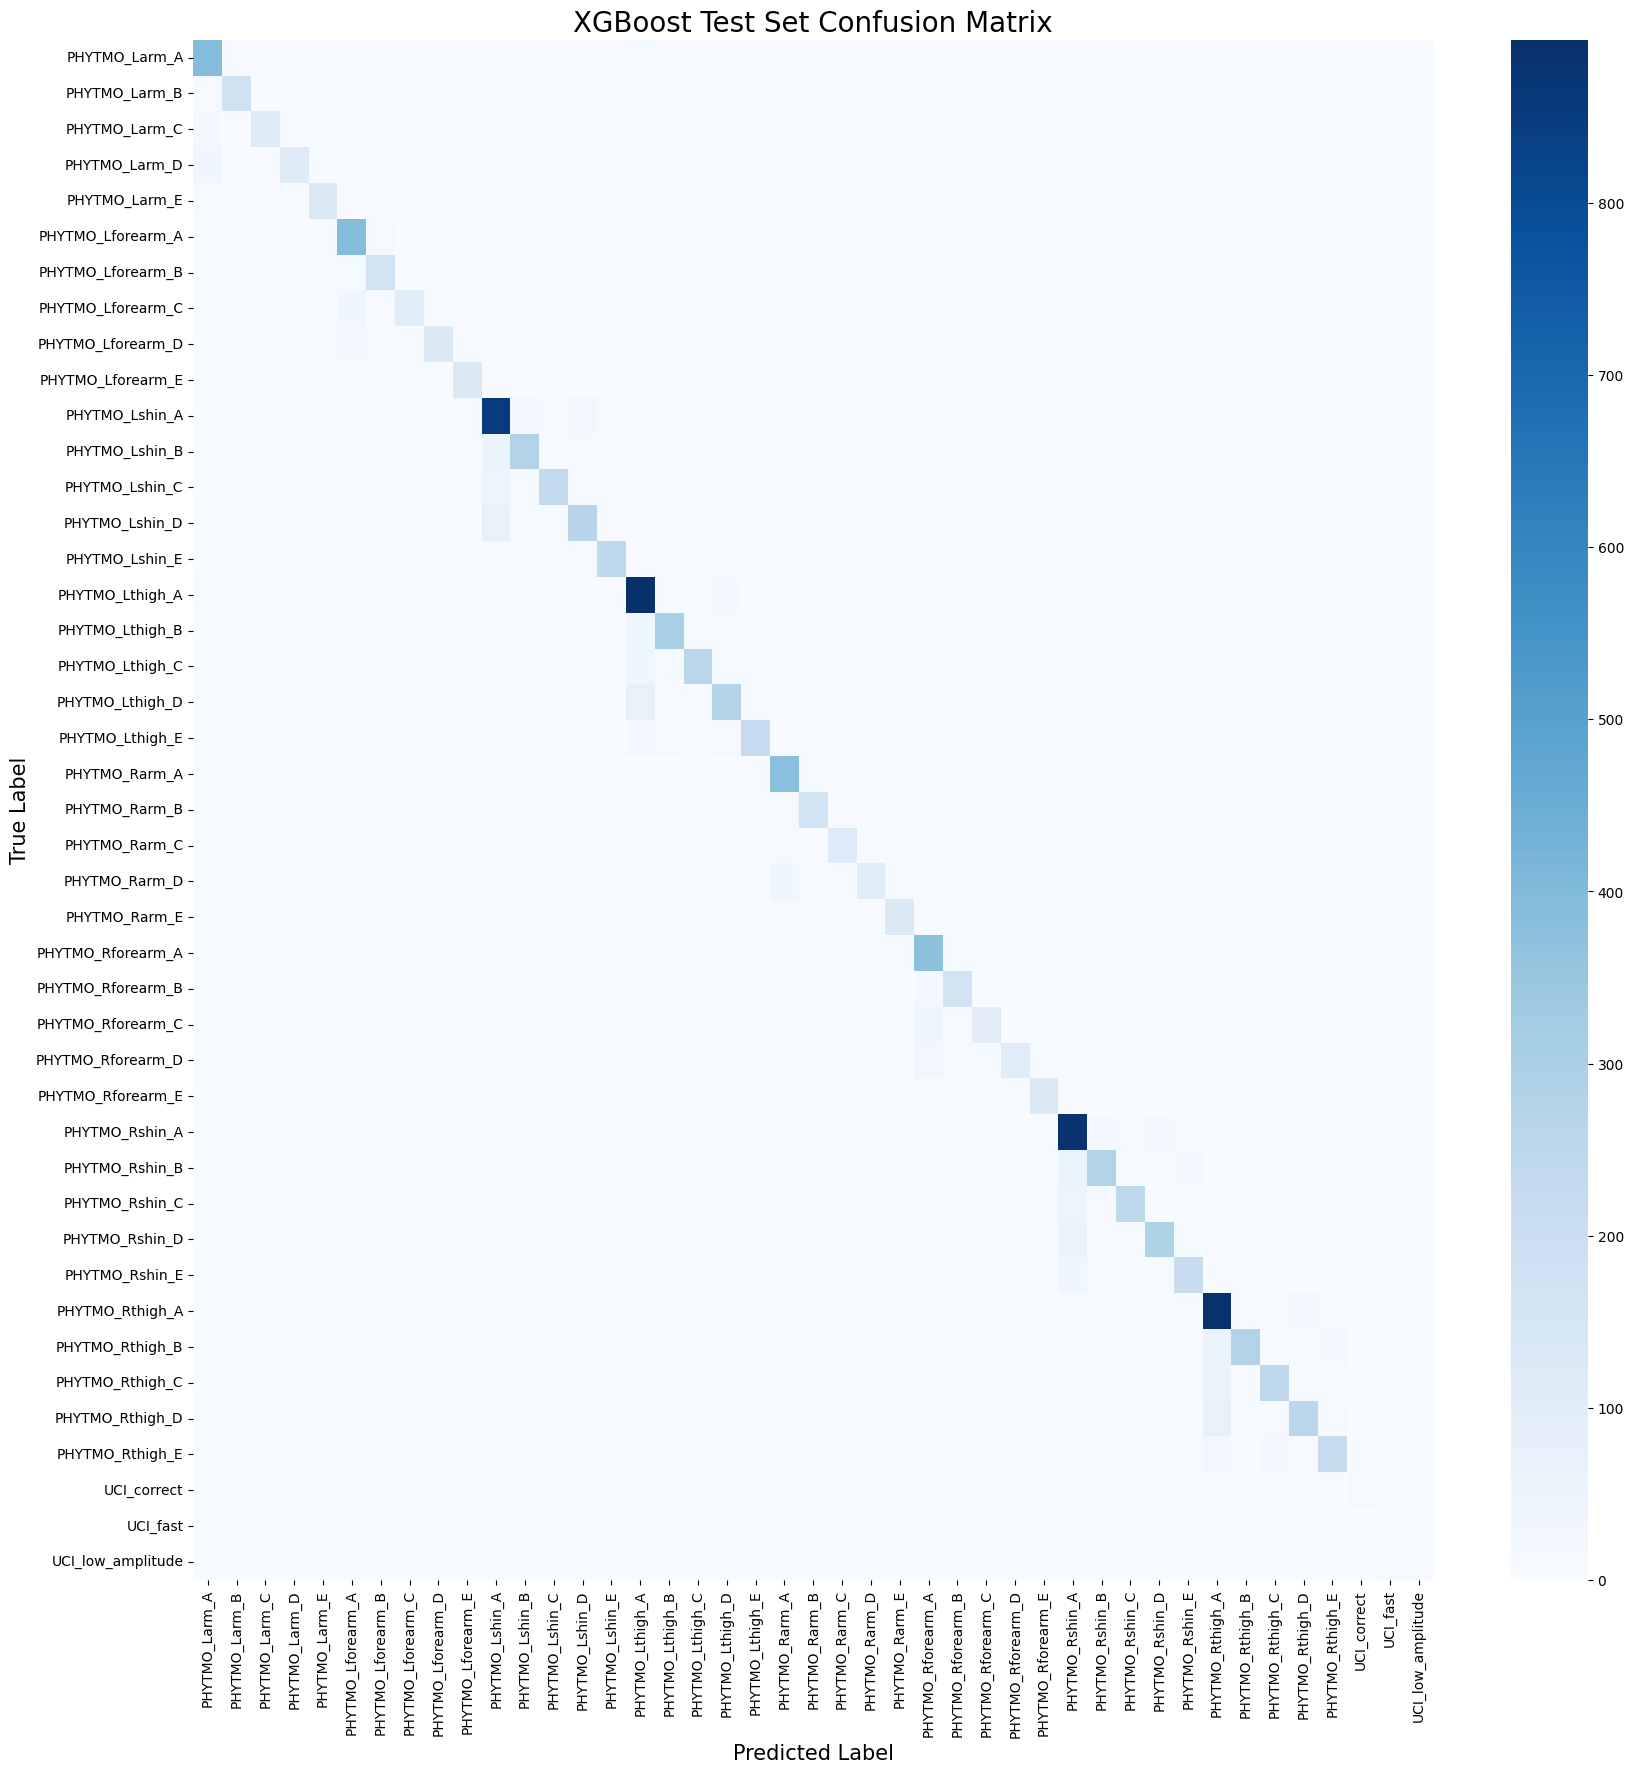

In [34]:
cm = confusion_matrix(y_test, yp_test_xgb)

plt.figure(figsize=(20, 20)) # Needs to be large for 43 classes
sns.heatmap(cm, annot=False, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('XGBoost Test Set Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.show()

# Step 14: Feature Importance (for best model: XGBoost)

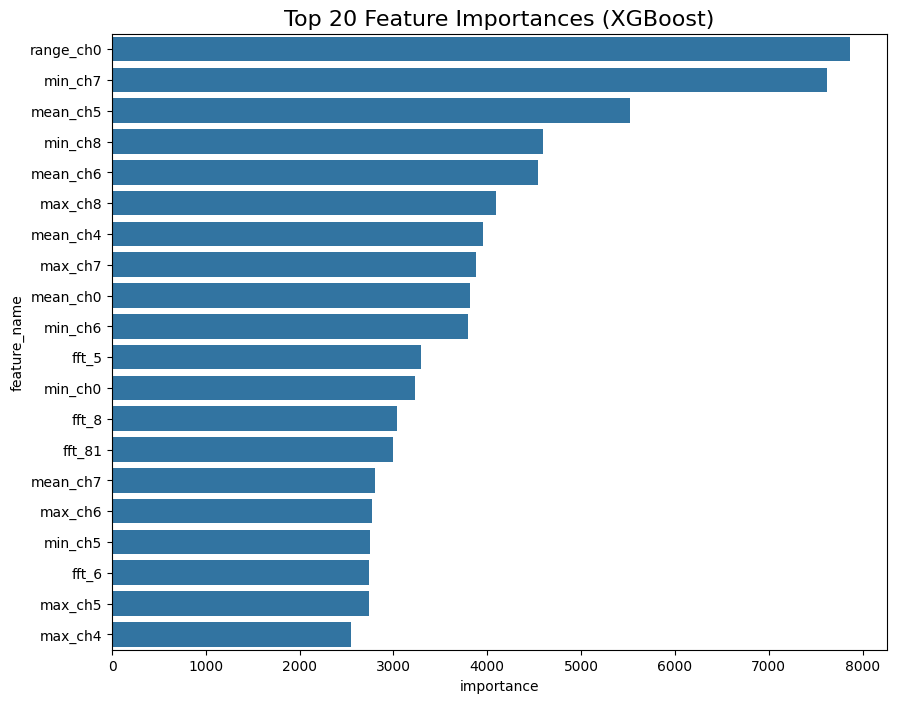

In [35]:

# Create basic feature names to make the plot readable
f_names = []
stats = ['mean', 'std', 'max', 'min', 'range']
for stat in stats:
    for i in range(9): # 9 channels
        f_names.append(f'{stat}_ch{i}')
for i in range(90): # 10 FFT components * 9 channels
    f_names.append(f'fft_{i}')

# Get importances from the trained XGB model
importances = xgb_model.get_score(importance_type='weight')

# Map the default 'f0', 'f1' names from XGBoost to our names
importance_df = pd.DataFrame({
    'feature_index': [int(f.replace('f', '')) for f in importances.keys()],
    'importance': importances.values()
})
importance_df['feature_name'] = importance_df['feature_index'].apply(lambda x: f_names[x] if x < len(f_names) else f'f{x}')

# Sort and get top 20
top_20 = importance_df.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature_name', data=top_20)
plt.title('Top 20 Feature Importances (XGBoost)', fontsize=16)
plt.show()

# Step 15: Feature Importance (Random Forest)

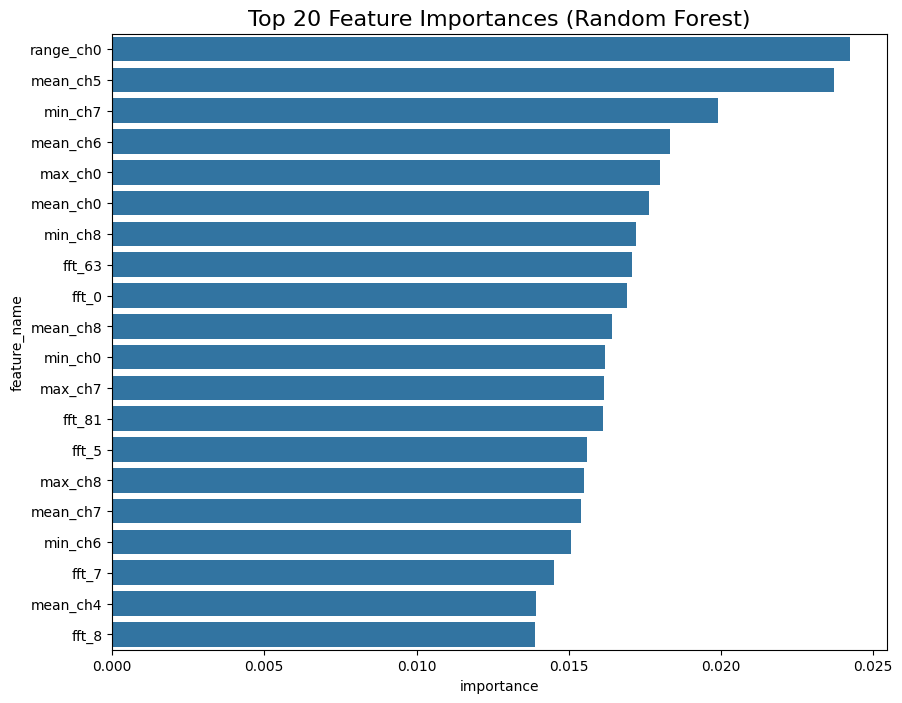

In [36]:
# Get importances from the trained RF model
importances_rf = rf.feature_importances_

# We can use the same f_names list from the cell above
importance_df_rf = pd.DataFrame({
    'feature_name': f_names,
    'importance': importances_rf
})

# Sort and get top 20
top_20_rf = importance_df_rf.sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature_name', data=top_20_rf)
plt.title('Top 20 Feature Importances (Random Forest)', fontsize=16)
plt.show()

# Step 16: Save models

In [37]:
import joblib

# Save the Random Forest model
joblib.dump(rf, "rf_combined_split.pkl")

# Save the XGBoost model
joblib.dump(xgb_model, "xgb_combined_split.pkl")

# Save the StandardScaler
joblib.dump(scaler, "scaler_combined_split.pkl")

print("Successfully saved models (rf, xgb) and scaler to disk.")

Successfully saved models (rf, xgb) and scaler to disk.
